 # <strong>Road networks and robustness to flooding on US Atlantic and Gulf barrier islands</strong>
 ## <strong>- Road network robustness to flooding -</strong>
 ### The purpose of this notebook is to identify, for each barrier island, the elevation and exceedance probability of the critical node that causes the network's failure and the overall robustness of each road network to flood-induced failures.

In [4]:
# Packages
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import contextily as ctx
import statistics
from scipy import stats


In [5]:
### Set working directory
path='E:\\Networks'
os.chdir(path)


FL11
FL12
FL13
FL14
FL15
FL16
FL17
FL19
FL2
FL20
FL21
FL23
FL24
FL28
FL29
FL30
FL31
FL35
FL36
FL37
FL38
FL4
FL7
FL8
GA10
GA3
GA8
LA13
LA4
LA5
LA7
LA8
NC11
NC13
NC14
NC16
NC18
NC20
NC21
NC8
NJ1


MemoryError: 

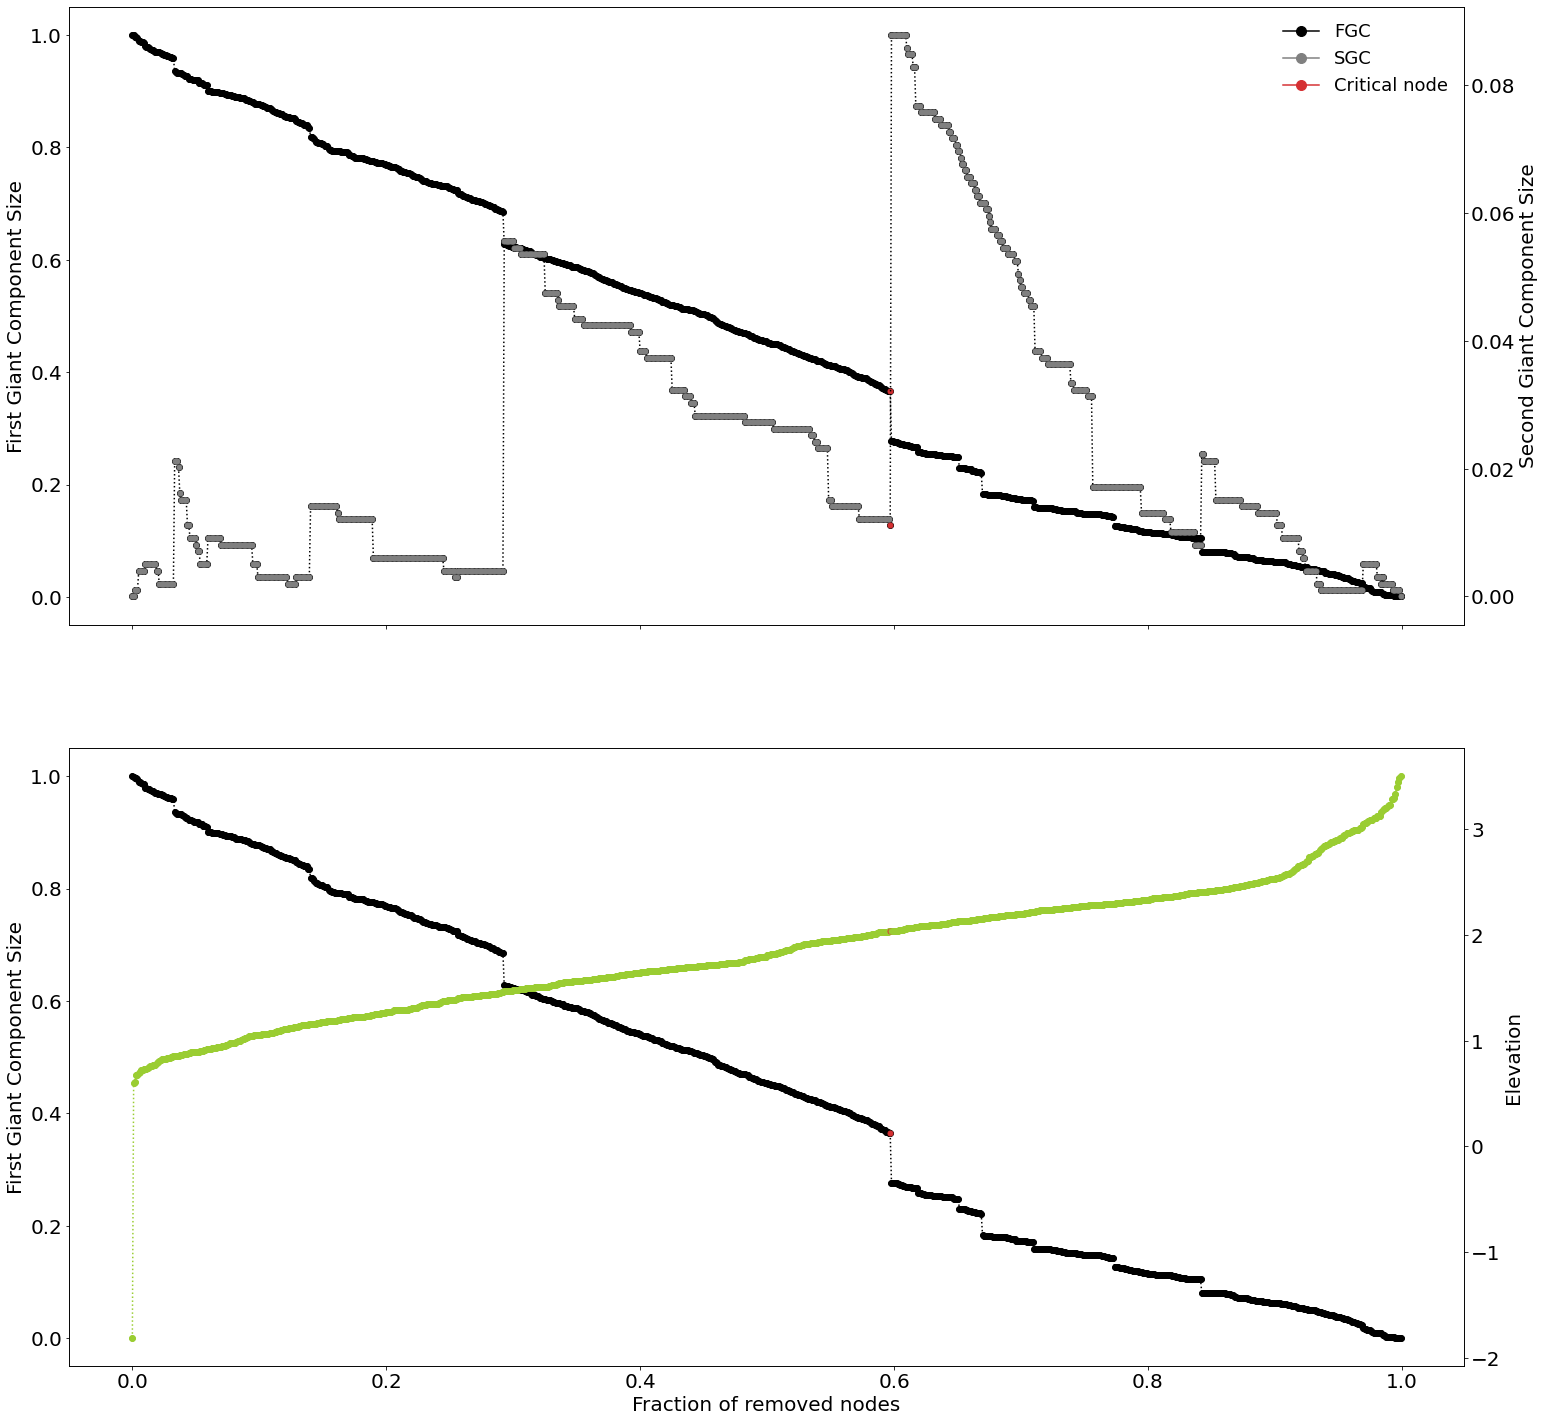

In [6]:
%%time

### Explore the size decay of the GCC to identify the critical node that leads to the fragmentation of the network (road networks with more than 100 nodes) and plot maps with road networks

# Create folders if they don't exist
outdir= '.\\Results'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
outdir= '.\\Results\\GCC_Plots'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
outdir= '.\\Results\\Networks_Maps'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    

# Loop through files to open each barrier graphml
rootdir = '.\\Data\\Roads'
extensions = ('.graphml')

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            print(barrier)
            G = nx.read_graphml(file_path)
            GCCs=[] # list with the number of connected components and its size
            # pull out elevation attribute
            Z = nx.get_node_attributes(G,'Elevations')
            # convert str values in float to be able to sort them 
            Z = dict(zip(Z.keys(), [float(value) for value in Z.values()]))
            # sort elevation values in ascending order
            Sorted_Z = sorted(Z.items(), key=lambda item: item[1])
            # select first element of each tuple in the list (nodes ID):
            FT = [i[0] for i in Sorted_Z]
            # Select second element of each tuple in the list (elevation) and convert to float
            ST = [i[1] for i in Sorted_Z]
            for i in range(len(ST)):
                ST[i] = float(ST[i])
            # create array 
            CCs = np.zeros([len(Sorted_Z),2])
            # loop through all nodes
            for i in range(0, len(FT)):
                # find the node with lowest elevation from the list using i and remove it
                G.remove_nodes_from(FT[0:i])
                # find the number of connected components and its respective size
                GCC = [len(c)
                        for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)
                    ]
                GCCs.append(GCC) 
                # fill array, first column corresponds to FGC (first giant component), second column to SGC (second giant component)
                if len(GCC)==1:
                    CCs[int(i),0]=GCC[0]/len(FT)
                    CCs[int(i),1]=0
                else:
                    CCs[int(i),0]=GCC[0]/len(FT)
                    CCs[int(i),1]=GCC[1]/len(FT)
            # find the node that, once removed, the size of the FGC drops abruptly while the size of the SGC reaches its maximum
            m = max(CCs[:,1])
            pos=[i for i, j in enumerate(CCs[:,1]) if j == m]
            pos= pos[0] # position of max value in SGC
            critical= pos-1 # position of the critical node whose removal causes the percolation transition.
            elev=ST[critical] # find elevation of the critical node
            removed=pos # number of nodes removed when percolation threshold occurs

            # plot
            col1=[] 
            for i in range(0,len(FT)):
                if i==critical:
                    col1.append('#D53032') 
                else:
                    col1.append('#000000')  
            col2=[]
            for i in range(0,len(FT)):
                if i==critical:
                    col2.append('#D53032') 
                else:
                    col2.append('#808080') 
            col3=[]
            for i in range(0,len(FT)):
                if i==critical:
                    col3.append('#D53032') 
                else:
                    col3.append('#9ACD32') 

            f, (ax1,ax2) = plt.subplots(2, 1, sharex=True)

            x_coord = 1 * np.arange(len(FT))/len(FT) # fraction of nodes removed
            ax1.plot(x_coord, CCs[:,0],':ok') # FGC
            for i in range (len(FT)):
                ax1.plot(x_coord[i],CCs[i,0],'o', markersize=5, color=col1[i]) # plot with two colors to highlight critical node
            ax1.set_ylabel("First Giant Component Size")
            ax3 = ax1.twinx()
            ax3.plot(x_coord, CCs[:,1],':ok') # SGC
            for i in range (len(FT)):
                ax3.plot(x_coord[i],CCs[i,1],'o', markersize=5, color=col2[i]) 
            ax3.set_ylabel("Second Giant Component Size")
            ax2.plot(x_coord,CCs[:,0],':ok') # FGC
            for i in range (len(FT)):
                ax2.plot(x_coord[i],CCs[i,0],'o', markersize=5, color=col1[i]) 
            ax2.set_ylabel("First Giant Component Size")
            ax4 = ax2.twinx()
            ax4.plot(x_coord,ST,':o', color='#9ACD32') # elevation
            for i in range (len(FT)):
                ax4.plot(x_coord[i],ST[i],'o', markersize=5, color=col3[i]) 
            ax2.set_ylabel("First Giant Component Size",)
            ax4.set_ylabel("Elevation")
            ax2.set_xlabel("Fraction of removed nodes") 
            legend_elements1 = [Line2D([0], [0], marker='o', color='#000000', label='FGC', markersize=10),
                                Line2D([0], [0], marker='o', color='#808080', label='SGC', markersize=10),
                                Line2D([0], [0], marker='o', color='#D53032', label='Critical node', markersize=10)]
            ax1.legend(handles=legend_elements1, loc="best", frameon=False, fontsize=18)
            legend_elements2 = [Line2D([0], [0], marker ='o', color='#000000', label='FGC', markersize=10),
                               Line2D([0], [0], marker='o', color='#9ACD32', label='Elevation', markersize=10)]
            ax1.legend(handles=legend_elements1, loc="best", frameon=False, fontsize=18)

            plt.rcParams["font.size"]= 20
            plt.rcParams["figure.figsize"] = (15,15)

            f.savefig(".\\Results\\GCC_Plots\{0}.png".format(barrier), dpi=500, facecolor='w')
            plt.close()

            ### Static maps for each network using OSM as basemap 
            
            # read polygons
            poly = gpd.read_file(".\\Data\\Barriers\\Barriers_AtlGulf\\{0}_geo.shp".format(barrier))
            # extract just the geometry (shapely object) part and clean it with a buffer
            poly_geo = poly['geometry'].iloc[0]
            poly_geo = poly_geo.buffer(0)
            poly_geo.is_valid
            # extract drivable network and project it
            graph = ox.graph_from_polygon(poly_geo, network_type='drive', simplify=True, clean_periphery=True)
            # retrieve nodes and edges as geodataframes
            nodes, edges = ox.graph_to_gdfs(graph)
            # create an index for the geodataframe nodes
            nodes['index'] = range(0, len(nodes))

            # convert Z dict in pandas dataframe and name columns
            Z = pd.DataFrame(list(Z.items()),columns = ['index','elevation'])
            # convert all columns in numerics so there are no errors when merging
            Z = Z.apply(pd.to_numeric)
            # join pandas dataframe to nodes geodataframe using 'index' so that the gdf has elevation
            nodes = nodes.merge(Z, on='index')

            # create new columns for color and size
            def color(row):
                if row['elevation'] < elev:
                    val = "black"
                elif row['elevation']== elev:
                    val = "red"
                else:
                    val = "green"
                return val

            def size(row):
                if row['elevation'] == elev:
                    val = 50
                else:
                    val = 30
                return val

            nodes['Color'] = nodes.apply(color, axis=1) # New column with color categories 
            nodes['Size'] = nodes.apply(size, axis=1) # New column with size categories

            # plot map using OSM as basemap
            fig, ax = plt.subplots()
            nodes = nodes.to_crs(epsg=3857) # convert gdf to EPSG used by basemaps
            edges = edges.to_crs(epsg=3857)
            nodes.plot(ax=ax, color=nodes.Color, markersize=nodes.Size, zorder=2, legend=True) # plot nodes
            edges.plot(ax=ax, alpha=0.2, color='black', zorder=1) # plot edges
            ctx.add_basemap(ax, zoom=13, source=ctx.providers.OpenStreetMap.Mapnik) # add basemap (OSM)
            plt.xticks(fontsize=12) # reduce fontsize of x axis
            plt.yticks(fontsize=12) # reduce fontsize of y axis
            legend_elements = [Line2D([0], [0], marker='o', color='black', label='Connected nodes',
                                      markerfacecolor='g', markersize=10),
                               Line2D([0], [0], marker='o', color='black', label='Disconnected nodes',
                                      markerfacecolor='b', markersize=10),
                               Line2D([0], [0], marker='o', color='black', label='Target node',
                                      markerfacecolor='r', markersize=10),
                               ] # create legend
            ax.legend(handles=legend_elements, loc='best', frameon=False)
            ax.set_title(barrier, fontsize=22)
            ax.ticklabel_format(style='plain')         
            plt.rcParams["figure.figsize"] = (25,25)
            plt.savefig('.\\Results\\Networks_Maps\\{0}.png'.format(barrier), dpi=300, facecolor='w')   
            plt.close()

In [ ]:
### Create table with information for each barrier 

barriers=[] # barrier name
n_nodes=[] # number of nodes
r=[] # robustness 
min_z=[] # min node elevation in the network
max_z=[] # max node elevation in the network
mean_z=[] # mean node elevation
median_z=[] # median node elevation
critical_z=[] # elevation critical node
critical_e=[] # exceedance probability critical node (given in return period)
removed_nodes=[] # number of nodes removed when critical node is removed
removed_perc=[] # percentage of nodes removed when critical node is removed
threshold=[] # value critical threshold


rootdir = '.\\Results\\Graphs'
extensions = ('.graphml')

# Loop through files and open barrier graphml
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext in extensions:
            file_path = os.path.join(subdir, file)
            barrier = file.replace(".graphml","")
            G = nx.read_graphml(file_path)
            if len(G.nodes(data=True))>100:
                GCCs=[]
                N= len(G.nodes(data=True))
                barriers.append(barrier) 
                n_nodes.append(N) 
                # pull out elevation attribute
                Z = nx.get_node_attributes(G,'Elevations')
                # convert str values in float to be able to sort them 
                Z = dict(zip(E.keys(), [float(value) for value in Z.values()]))
                # sort it based on elevation, min first
                Sorted_Z = sorted(Z.items(), key=lambda item: item[1])
                CCs = np.zeros([len(Sorted_Z),2])
                # select first element of each tuple in the list (nodes ID):
                FT = [i[0] for i in Sorted_Z]
                # select second element of each tuple in the list (elevation) and convert to float
                ST = [i[1] for i in Sorted_Z]
                for i in range(len(ST)):
                    ST[i] = float(ST[i])
                

                # calculate elevation stats 
                min_elev=min(ST)
                min_z.append(min_elev)
                max_elev=max(ST)
                max_z.append(max_elev)
                mean_elev = statistics.mean(ST)
                mean_z.append(mean_elev)
                median_elev = statistics.median(ST)
                median_z.append(median_elev)
                

                # remove nodes by elevation and calculate size of first and second components
                for i in range(0, len(FT)):
                    # find the node with lowest elevation from the list using i and remove it
                    G.remove_nodes_from(FT[0:i])
                    # find the number of connected components and its respective size
                    GCC = [len(c)
                            for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)
                        ]
                    GCCs.append(GCC) # list with the number of connected components and its size
                    # fill array, first column corresponds to FGC (first giant component), second column to SGC (second giant component)
                    if len(GCC)==1:
                        CCs[int(i),0]=GCC[0]/len(FT)
                        CCs[int(i),1]=0
                    else:
                        CCs[int(i),0]=GCC[0]/len(FT)
                        CCs[int(i),1]=GCC[1]/len(FT)

                # find the node that, once removed, the FGC decreases and the SGC reaches its maximum (critical threshold)
                m = max(CCs[:,1])
                pos=[i for i, j in enumerate(CCs[:,1]) if j == m]
                pos= pos[0] # position of max value in SGC
                critical= pos-1 # position of the critical node whose removal causes the percolation transition.
                elev=ST[critical] # find elevation of the critical node
                critical_z.append(elev)
                removed=pos # number of nodes removed when percolation threshold occurs
                removed_nodes.append(removed)
                perc_removed=int(removed)/N*100
                removed_perc.append(perc_removed)
                x_coord = 1 * np.arange(len(FT))/len(FT) # Fraction of nodes removed
                thresh= x_coord[critical]
                threshold.append(thresh)

                # exceedance probability for the critical node
                exceed = pd.read_csv(".\\Data\\Exceedance\\Probability\\{0}_Exceedance.csv".format(barrier), sep=",", header=0)
                exceed_x= exceed.MaxWL
                exceed_y= exceed.Return_Pd
                node_elev= elev
                exceedance= np.interp(node_elev, exceed_x, exceed_y)
                critical_e.append(exceedance)

                # calculate robustness following Schneider's equation (2011) 
                s= sum(CCs[:,0])
                rob= s/len(FT)
                r.append(rob)
            else:
                continue
table = list(zip(barriers,n_nodes,r,min_z,max_z,mean_z,median_z,critical_z,critical_e,removed_nodes,removed_perc,threshold))
table = pd.DataFrame(table, columns=['Barrier','Nodes','Robustness','Min_elevation','Max_elevation','Mean_elevation','Median_elevation','Critical_elevation','Critical_Exceedance','Removed_nodes','Removed_%','Critical_threshold'])
table.to_csv('.\\Results\\Table2.csv')
